# Hate speech

### 1. Data import and error removal

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm

In [2]:
all_files_paths = glob.glob("hate-speech-dataset/all_files/*.txt")

In [3]:
all_files_paths = [f for f in all_files_paths if os.path.isfile(f)]

In [4]:
all_files_names = [f.replace("hate-speech-dataset/all_files\\", "").replace(".txt", "") for f in all_files_paths]

In [5]:
txt_content = {}
errors = []
for name, path in tqdm(list(zip(all_files_names, all_files_paths))):
    with open(path, "r") as txt:
        try:
            txt_content[name] = txt.readline()
        except Exception as ex:
            errors.append((name, str(ex)))

100%|██████████| 10944/10944 [01:06<00:00, 163.90it/s]


In [6]:
errors

[('13491591_4',
  "'charmap' codec can't decode byte 0x81 in position 23: character maps to <undefined>"),
 ('13493456_1',
  "'charmap' codec can't decode byte 0x81 in position 169: character maps to <undefined>"),
 ('13500400_1',
  "'charmap' codec can't decode byte 0x81 in position 67: character maps to <undefined>"),
 ('13560796_1',
  "'charmap' codec can't decode byte 0x81 in position 5: character maps to <undefined>"),
 ('13572081_1',
  "'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>"),
 ('13588794_3',
  "'charmap' codec can't decode byte 0x81 in position 54: character maps to <undefined>"),
 ('13595072_1',
  "'charmap' codec can't decode byte 0x8d in position 75: character maps to <undefined>"),
 ('13595072_5',
  "'charmap' codec can't decode byte 0x8d in position 78: character maps to <undefined>"),
 ('14061724_1',
  "'charmap' codec can't decode byte 0x81 in position 181: character maps to <undefined>"),
 ('14065492_1',
  "'charmap' codec ca

In [7]:
errors_list = [err[0] for err in errors]

In [8]:
df = pd.DataFrame.from_dict(txt_content, orient='index').reset_index()

In [9]:
df.columns = ["file_id", "text"]

In [10]:
df.head()

,file_id,text
0,12834217_1,"As of March 13th , 2014 , the booklet had been..."
1,12834217_10,Thank you in advance. : ) Download the youtube...
2,12834217_2,In order to help increase the booklets downloa...
3,12834217_3,( Simply copy and paste the following text int...
4,12834217_4,Click below for a FREE download of a colorfull...


In [11]:
ann = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')

In [12]:
ann

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate
...,...,...,...,...,...
10939,33676864_5,734541,1388,0,noHate
10940,33677019_1,735154,1388,0,noHate
10941,33677019_2,735154,1388,0,noHate
10942,33677053_1,572266,1388,0,hate


In [13]:
ann = ann[~ann['file_id'].isin(errors_list)]

In [14]:
data = pd.merge(left=ann, right=df, left_on='file_id', right_on='file_id')
data.shape
data

,file_id,user_id,subforum_id,num_contexts,label,text
0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...
...,...,...,...,...,...,...
10921,33676864_5,734541,1388,0,noHate,"Billy - `` That guy would n't leave me alone ,..."
10922,33677019_1,735154,1388,0,noHate,Wish we at least had a Marine Le Pen to vote f...
10923,33677019_2,735154,1388,0,noHate,Its like the choices are white genocide candid...
10924,33677053_1,572266,1388,0,hate,Why White people used to say that sex was a si...


In [15]:
data['label'] = data.apply(lambda x: 0 if x['label'] == "noHate" else 1, axis=1)

In [16]:
data

,file_id,user_id,subforum_id,num_contexts,label,text
0,12834217_1,572066,1346,0,0,"As of March 13th , 2014 , the booklet had been..."
1,12834217_2,572066,1346,0,0,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,0,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,1,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,0,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...
...,...,...,...,...,...,...
10921,33676864_5,734541,1388,0,0,"Billy - `` That guy would n't leave me alone ,..."
10922,33677019_1,735154,1388,0,0,Wish we at least had a Marine Le Pen to vote f...
10923,33677019_2,735154,1388,0,0,Its like the choices are white genocide candid...
10924,33677053_1,572266,1388,0,1,Why White people used to say that sex was a si...


### 2. Cleaning and tokenization

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
import nltk.sentiment.vader as vd
from nltk import download
download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### 2.1 Removing links, tags, numbers and bias

In [18]:
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'), additional, string.punctuation)
data['text_clean'] = data['text'].str.lower()\
    .str.replace('(@[a-z0-9]+)\w+',' ')\
    .str.replace('(http\S+)', ' ')\
    .str.replace('(www\S+)',' ')\
    .str.replace(r"com$", ' ')\
    .str.replace('[0-9]+(?:st| st|nd| nd|rd| rd|th| th)', '')\
    .str.replace('([^a-z \t])',' ')\
    .str.replace(' +',' ')\
    .apply(lambda x: " ".join([i for i in x.split() if not i in swords]))
#any alpha numeric after @ #http # any value except alpha numeric tab character ('\u0009')

In [19]:
# Stemming
ps = PorterStemmer()
data['stemmed'] = data['text_clean'].apply(lambda x: " ".join([ps.stem(i) for i in word_tokenize(x)]))

In [20]:
# Lemmatizer
lm = nltk.WordNetLemmatizer()
data['lemmatized'] = data['text_clean'].apply(lambda x: " ".join([lm.lemmatize(i) for i in word_tokenize(x)]))

In [21]:
data

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized
0,12834217_1,572066,1346,0,0,"As of March 13th , 2014 , the booklet had been...",march booklet downloaded times counting,march booklet download time count,march booklet downloaded time counting
1,12834217_2,572066,1346,0,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,order help increas booklet download would grea...,order help increase booklet downloads would gr...
2,12834217_3,572066,1346,0,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,simpli copi past follow text youtub video desc...,simply copy paste following text youtube video...
3,12834217_4,572066,1346,0,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,click free download color illustr page e book ...,click free download colorfully illustrated pag...
4,12834217_5,572066,1346,0,0,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,click download mb green banner link,click download mb green banner link,click download mb green banner link
...,...,...,...,...,...,...,...,...,...
10921,33676864_5,734541,1388,0,0,"Billy - `` That guy would n't leave me alone ,...",billy guy would n leave alone gave trudeau salute,billi guy would n leav alon gave trudeau salut,billy guy would n leave alone gave trudeau salute
10922,33677019_1,735154,1388,0,0,Wish we at least had a Marine Le Pen to vote f...,wish least marine le pen vote canada,wish least marin le pen vote canada,wish least marine le pen vote canada
10923,33677019_2,735154,1388,0,0,Its like the choices are white genocide candid...,like choices white genocide candidate,like choic white genocid candid,like choice white genocide candidate
10924,33677053_1,572266,1388,0,1,Why White people used to say that sex was a si...,white people used say sex sin used mystery saw...,white peopl use say sex sin use mysteri saw ch...,white people used say sex sin used mystery saw...


#### 2.3 Bow and Tfidf

In [22]:
# Bow vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(data['lemmatized'])

In [23]:
print(bow_vectorizer.get_feature_names())

['ab', 'abandon', 'abandoned', 'abbey', 'abc', 'abduction', 'abhor', 'abiding', 'ability', 'abit', 'able', 'aboard', 'abominable', 'abomination', 'aborigine', 'aborigional', 'aborted', 'abortion', 'abound', 'abouts', 'abraham', 'abroad', 'absolut', 'absolute', 'absolutely', 'absorbing', 'absurd', 'absurdity', 'abt', 'abundant', 'abuse', 'abused', 'abusing', 'abusive', 'ac', 'acadamys', 'academia', 'academic', 'academy', 'accelerates', 'accent', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessible', 'accessing', 'accessory', 'accessouries', 'accident', 'accidentally', 'accommonadate', 'accomodation', 'accompaigned', 'accomplice', 'accomplish', 'accomplished', 'accomplishment', 'according', 'accordingly', 'accost', 'account', 'accountable', 'accountant', 'accounted', 'accross', 'accumulate', 'accuracy', 'accurate', 'accurately', 'accusation', 'accuse', 'accused', 'accusing', 'accutrigger', 'ache', 'achieve', 'achieved', 'achievement', 'achiever', 'acitivit

In [24]:
# Tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = tfidf_vectorizer.fit_transform(data['lemmatized'])
print(tfidf_vectorizer.get_feature_names())

['ago', 'also', 'always', 'anyone', 'anything', 'area', 'around', 'back', 'black', 'child', 'come', 'could', 'country', 'day', 'dont', 'even', 'ever', 'every', 'eye', 'find', 'first', 'friend', 'get', 'girl', 'go', 'god', 'going', 'good', 'got', 'great', 'group', 'guy', 'home', 'hope', 'im', 'ireland', 'jew', 'kid', 'know', 'last', 'let', 'like', 'little', 'live', 'long', 'look', 'looking', 'lot', 'make', 'man', 'many', 'maybe', 'much', 'nationalist', 'need', 'negro', 'never', 'new', 'news', 'non', 'nothing', 'old', 'one', 'people', 'place', 'post', 'put', 'race', 'read', 'really', 'right', 'said', 'saw', 'say', 'school', 'see', 'show', 'someone', 'something', 'start', 'take', 'talk', 'thing', 'think', 'thread', 'time', 'two', 'video', 'want', 'watch', 'way', 'week', 'well', 'white', 'woman', 'work', 'world', 'would', 'year', 'youtube']


In [25]:
pd.DataFrame(X_tfidf[1:11,7:23].toarray(), columns=list(tfidf_vectorizer.vocabulary_.keys())[7:23])

,white,back,world,jew,think,black,every,get,look,hope,one,say,read,well,always,like
0,0.000000,0.000000,0.0,0.0,0.382474,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
5,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
6,0.443277,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
7,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
8,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
9,0.000000,0.377809,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.472976,0.0,0.0,0.0,0.0,0.382452


In [26]:
# https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [27]:
common_words = get_top_n_words(data['lemmatized'], 50)
cmw = {}
for word, freq in common_words:
    #print(word, freq)
    cmw[word] = freq

In [28]:
mcw = pd.DataFrame.from_dict(cmw, orient='index').reset_index()
mcw.columns = ["words", "freq"]

In [29]:
mcw # Most common words between lemmatized words and frequencies

,words,freq
0,white,1596
1,like,803
2,people,630
3,black,619
4,one,569
5,get,523
6,would,515
7,youtube,470
8,year,420
9,time,396


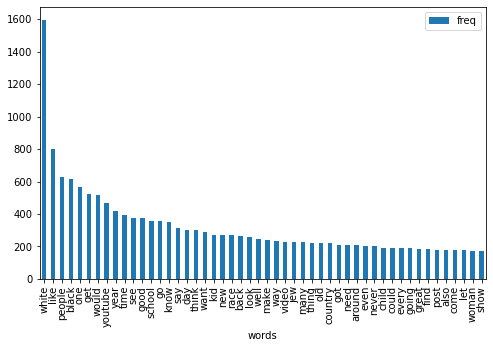

In [30]:
import matplotlib.pyplot as plt
mcw.plot(x="words", y="freq", kind="bar", figsize=(8,5))
plt.show()

In [31]:
data['tokens'] = data['text_clean'].apply(word_tokenize)

In [32]:
data

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized,tokens
0,12834217_1,572066,1346,0,0,"As of March 13th , 2014 , the booklet had been...",march booklet downloaded times counting,march booklet download time count,march booklet downloaded time counting,"[march, booklet, downloaded, times, counting]"
1,12834217_2,572066,1346,0,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,order help increas booklet download would grea...,order help increase booklet downloads would gr...,"[order, help, increase, booklets, downloads, w..."
2,12834217_3,572066,1346,0,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,simpli copi past follow text youtub video desc...,simply copy paste following text youtube video...,"[simply, copy, paste, following, text, youtube..."
3,12834217_4,572066,1346,0,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,click free download color illustr page e book ...,click free download colorfully illustrated pag...,"[click, free, download, colorfully, illustrate..."
4,12834217_5,572066,1346,0,0,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,click download mb green banner link,click download mb green banner link,click download mb green banner link,"[click, download, mb, green, banner, link]"
...,...,...,...,...,...,...,...,...,...,...
10921,33676864_5,734541,1388,0,0,"Billy - `` That guy would n't leave me alone ,...",billy guy would n leave alone gave trudeau salute,billi guy would n leav alon gave trudeau salut,billy guy would n leave alone gave trudeau salute,"[billy, guy, would, n, leave, alone, gave, tru..."
10922,33677019_1,735154,1388,0,0,Wish we at least had a Marine Le Pen to vote f...,wish least marine le pen vote canada,wish least marin le pen vote canada,wish least marine le pen vote canada,"[wish, least, marine, le, pen, vote, canada]"
10923,33677019_2,735154,1388,0,0,Its like the choices are white genocide candid...,like choices white genocide candidate,like choic white genocid candid,like choice white genocide candidate,"[like, choices, white, genocide, candidate]"
10924,33677053_1,572266,1388,0,1,Why White people used to say that sex was a si...,white people used say sex sin used mystery saw...,white peopl use say sex sin use mysteri saw ch...,white people used say sex sin used mystery saw...,"[white, people, used, say, sex, sin, used, mys..."


#### 2.2 Part of speech (POS)

In [33]:
# POS
from textblob import TextBlob
def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

In [34]:
from textblob import TextBlob
TextBlob(data.iloc[4]["text_clean"]).tags

[('click', 'NN'),
 ('download', 'NN'),
 ('mb', 'NN'),
 ('green', 'JJ'),
 ('banner', 'NN'),
 ('link', 'NN')]

In [35]:
TextBlob(data.iloc[4]["stemmed"]).tags

[('click', 'NN'),
 ('download', 'NN'),
 ('mb', 'NN'),
 ('green', 'JJ'),
 ('banner', 'NN'),
 ('link', 'NN')]

In [36]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [37]:
data['POS_spacy'] = data['lemmatized'].apply(lambda x: [(token.text, token.pos_) for token in nlp(x)])

In [38]:
data.iloc[4]["POS_spacy"]

[('click', 'VERB'),
 ('download', 'PROPN'),
 ('mb', 'PROPN'),
 ('green', 'ADJ'),
 ('banner', 'NOUN'),
 ('link', 'NOUN')]

In [39]:
all_pos = data['POS_spacy'].sum()

In [40]:
all_adjs = [x[0] for x in all_pos if x[1] == "ADJ"]

In [41]:
all_nouns = [x[0] for x in all_pos if x[1] == "NOUN"]

In [42]:
adj_counter = {}
for word in all_adjs:
    if word in adj_counter:
        adj_counter[word] += 1
    else:
        adj_counter[word] = 1
            
popular_adj = pd.DataFrame(sorted(adj_counter, key = adj_counter.get, reverse = True))
popular_adj.columns = ["ADJECTIVES"]
top_20_adj = popular_adj[:20]
top_20_adj

,ADJECTIVES
0,white
1,black
2,good
3,many
4,old
5,new
6,last
7,great
8,non
9,little


popular_adj.plot(y=adj_counter.get, x=adj_counter, kind = "bar")

In [43]:
noun_counter = {}
for word in all_nouns:
    if word in noun_counter:
        noun_counter[word] += 1
    else:
        noun_counter[word] = 1
            
popular_noun = pd.DataFrame(sorted(noun_counter, key = noun_counter.get, reverse = True))
popular_noun.columns = ["NOUNS"]
top_20_noun = popular_noun[:20]
top_20_noun

,NOUNS
0,people
1,year
2,time
3,school
4,race
5,day
6,thing
7,country
8,child
9,video


In [44]:
hate = data.loc[data["label"] == 1]

In [45]:
all_pos_hate = hate['POS_spacy'].sum()

In [46]:
all_adjs_hate = [x[0] for x in all_pos_hate if x[1] == "ADJ"]
all_nouns_hate = [x[0] for x in all_pos_hate if x[1] == "NOUN"]

In [47]:
adj_counter1 = {}
for word in all_adjs_hate:
    if word in adj_counter1:
        adj_counter1[word] += 1
    else:
        adj_counter1[word] = 1
            
popular_adj1 = pd.DataFrame(sorted(adj_counter1, key = adj_counter1.get, reverse = True))
popular_adj1.columns = ["HATE - ADJECTIVES"]
top_20_adj1 = popular_adj1[:20]
top_20_adj1

,HATE - ADJECTIVES
0,white
1,black
2,non
3,good
4,many
5,last
6,negro
7,little
8,liberal
9,much


In [48]:
noun_counter1 = {}
for word in all_nouns_hate:
    if word in noun_counter1:
        noun_counter1[word] += 1
    else:
        noun_counter1[word] = 1
            
popular_noun1 = pd.DataFrame(sorted(noun_counter1, key = noun_counter1.get, reverse = True))
popular_noun1.columns = ["HATE - NOUNS"]
top_20_noun1 = popular_noun1[:20]
top_20_noun1

,HATE - NOUNS
0,people
1,race
2,country
3,time
4,woman
5,child
6,thing
7,school
8,way
9,ape


In [49]:
popular_adj = sorted(adj_counter, key = adj_counter.get, reverse = True)
top_20_adj = popular_adj[:20]
popular_adj1 = sorted(adj_counter1, key = adj_counter1.get, reverse = True)
top_20_adj1 = popular_adj1[:20]

In [50]:
top_adj = {"Total": top_20_adj, "Hate Speech": top_20_adj1}
top_adj = pd.DataFrame(top_adj)
top_adj

,Total,Hate Speech
0,white,white
1,black,black
2,good,non
3,many,good
4,old,many
5,new,last
6,last,negro
7,great,little
8,non,liberal
9,little,much


In [51]:
popular_noun = sorted(noun_counter, key = noun_counter.get, reverse = True)
top_20_noun = popular_noun[:20]
popular_noun1 = sorted(noun_counter1, key = noun_counter1.get, reverse = True)
top_20_noun1 = popular_noun1[:20]

In [52]:
top_noun = {"Total": top_20_noun, "# tot":noun_counter.get,  "Hate Speech": top_20_noun1}
top_noun = pd.DataFrame(top_noun)
top_noun

,Total,# tot,Hate Speech
0,people,<built-in method get of dict object at 0x00000...,people
1,year,<built-in method get of dict object at 0x00000...,race
2,time,<built-in method get of dict object at 0x00000...,country
3,school,<built-in method get of dict object at 0x00000...,time
4,race,<built-in method get of dict object at 0x00000...,woman
5,day,<built-in method get of dict object at 0x00000...,child
6,thing,<built-in method get of dict object at 0x00000...,thing
7,country,<built-in method get of dict object at 0x00000...,school
8,child,<built-in method get of dict object at 0x00000...,way
9,video,<built-in method get of dict object at 0x00000...,ape


C:\Users\marti\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


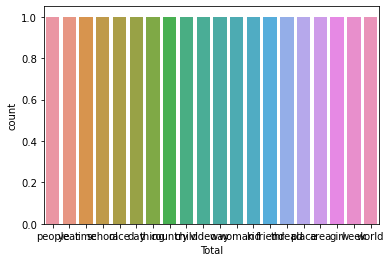

In [53]:
import seaborn as sns
sns.countplot(top_noun['Total'], label="Count")
plt.show()

import matplotlib.pyplot as plt
top_noun.plot(x= "Total", y= "# tot")

data['POS'] = data['lemmatized'].apply(pos_tag)

def get_adjectives(text):
    blob = TextBlob(text)
    return [word for (word,tag) in blob.tags if tag == "JJ" or tag == "JJR" or tag == "JJS"]

data['ADJ'] = data['lemmatized'].apply(get_adjectives)

adj = data['lemmatized'].apply(get_adjectives)
adj

adj_list = [j for i in adj for j in i]
adj_list

# https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
adj_counter = {}
for word in adj_list:
    if word in adj_counter:
        adj_counter[word] += 1
    else:
        adj_counter[word] = 1
            
popular_adj = sorted(adj_counter, key = adj_counter.get, reverse = True)
top_20_adj = popular_adj[:20]
top_20_adj

def get_noun(text):
    blob = TextBlob(text)
    return [word for (word,tag) in blob.tags if tag == "NN" or tag == "NNS" or tag == "NNP" or tag == "NNPS"]

data['NOUN'] = data['lemmatized'].apply(get_noun)

noun = data['lemmatized'].apply(get_noun)
noun_list = [j for i in noun for j in i]
noun_counter = {}
for word in noun_list:
    if word in noun_counter:
        noun_counter[word] += 1
    else:
        noun_counter[word] = 1
            
popular_noun = sorted(noun_counter, key = noun_counter.get, reverse = True)
top_20_noun = popular_noun[:20]
top_20_noun

adj1 = hate['lemmatized'].apply(get_adjectives)
adj_list1 = [j for i in adj1 for j in i]
adj_counter1 = {}
for word in adj_list1:
    if word in adj_counter1:
        adj_counter1[word] += 1
        
    else:
        adj_counter1[word] = 1
            
popular_adj1 = sorted(adj_counter1, key = adj_counter1.get, reverse = True)
top_20_adj1 = popular_adj1[:20]
top_20_adj1

noun1 = hate['lemmatized'].apply(get_noun)
noun_list1 = [j for i in noun1 for j in i]
noun_counter1 = {}
for word in noun_list1:
    if word in noun_counter1:
        noun_counter1[word] += 1
    else:
        noun_counter1[word] = 1
            
popular_noun1 = sorted(noun_counter1, key = noun_counter1.get, reverse = True)
top_20_noun1 = popular_noun1[:20]
top_20_noun1

In [54]:
pd.set_option('display.max_colwidth', None)
data['text'][0:10]

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              As of March 13th , 2014 , the booklet had been downloaded over 18,300 times and counting .
1                                                                                                                             

In [55]:
# Label (0,1)

In [56]:
data.loc[data['label'] == 1].shape # 1428 over 10926 rows

(1428, 11)

In [57]:
hate = data.loc[data['label'] == 1]

In [58]:
common_words = get_top_n_words(hate['lemmatized'], 50)
for word, freq in common_words:
    print(word,freq)

white 400
black 217
like 132
jew 117
people 106
would 94
negro 94
race 88
one 87
get 86
country 71
see 71
think 65
go 63
non 58
want 56
back 53
time 52
school 49
woman 48
even 48
make 47
asian 47
look 46
know 46
thing 45
way 45
kid 44
say 44
good 44
every 43
day 42
never 41
child 41
need 40
come 38
africa 38
liberal 37
ape 36
world 36
many 36
around 36
going 35
youtube 33
year 32
last 32
got 32
find 32
much 31
scum 31


In [59]:
common_words = get_top_n_words(all_adjs , 50)
for word, freq in common_words:
    print(word,freq)

white 944
black 460
good 337
many 226
old 194
new 183
last 159
great 151
non 131
little 114
much 111
bad 93
free 83
right 78
next 76
big 72
different 69
nationalist 68
high 68
first 65
small 62
long 61
public 61
jewish 60
best 60
least 60
german 59
beautiful 58
sure 58
real 57
live 56
full 55
irish 55
nice 54
true 54
able 52
racial 52
negro 50
young 49
whole 49
open 49
liberal 48
european 47
stupid 46
proud 44
better 43
wrong 43
anti 41
hard 40
local 40


In [60]:
common_words = get_top_n_words(all_nouns , 50)
for word, freq in common_words:
    print(word,freq)

people 624
year 387
time 367
school 274
race 256
day 231
thing 208
country 203
child 190
video 189
way 162
woman 150
kid 145
friend 137
thread 136
place 129
area 121
girl 120
week 118
world 110
site 110
teacher 107
work 105
person 103
man 102
family 99
eye 98
life 95
guy 90
youtube 88
group 88
word 85
problem 85
crime 81
today 81
home 81
town 81
picture 80
lot 80
story 79
nation 77
part 77
money 77
talk 77
skin 75
men 74
music 74
hair 73
brother 69
gun 69


In [61]:
common_words = get_top_n_words(all_adjs_hate , 50)
for word, freq in common_words:
    common_adj_hate = {"Total": word, "# tot":freq}

In [62]:
common_adj_hate

{'Total': 'yellow', '# tot': 8}

#### Sentiment analysis

In [63]:
# Sentiment Analysis by nltk VADER
sia = vd.SentimentIntensityAnalyzer()
data['sentiment_score'] = data['lemmatized'].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))

In [64]:
data.sentiment_score.unique()

array([ 0.    ,  1.345 , -0.0613, ...,  0.7524, -0.1933, -0.2308])

In [65]:
col1 = data['label']
col2 = data['sentiment_score']
correlation_df = col1.corr(col2)
print(correlation_df)

-0.11454004822119156


In [66]:
# RELATION BTW LABEL AND SENTIMETN_SCORE

# SPELLING

In [67]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [68]:
def unusual_words(text):
    text_vocab = set(w.lower() for w in text if w.isalpha())
    english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    unusual = text_vocab.difference(english_vocab)
    return sorted(unusual)

In [69]:
crt = unusual_words(data['lemmatized'])
print(crt)

['africa', 'aragorn', 'asked', 'asking', 'asmodean', 'bb', 'braun', 'btl', 'bugsy', 'calman', 'camie', 'cf', 'cheaper', 'congrats', 'cripppinnn', 'czynski', 'dallas', 'downloads', 'dr', 'dublin', 'ebonics', 'edmonton', 'einherjer', 'embarassing', 'fbi', 'flanative', 'groupid', 'gyspsies', 'haha', 'hahahahahaha', 'heil', 'hups', 'hz', 'ii', 'iii', 'im', 'internet', 'iv', 'kaboom', 'kid', 'kidding', 'kr', 'lk', 'located', 'lol', 'meh', 'minnesota', 'mmm', 'motivated', 'mrbadgersir', 'msciwoj', 'muahaha', 'needed', 'neofolk', 'nigga', 'nordenwulf', 'okay', 'opendocument', 'opps', 'oz', 'patrioticmama', 'pawel', 'pffffft', 'pm', 'politifuldm', 'reproducing', 'rumour', 'ssupreme', 'stormfront', 'studying', 'sveiks', 'swva', 'tereasa', 'tf', 'threadid', 'tnb', 'topix', 'tv', 'twp', 'ty', 'usa', 'vancouver', 'wehrwolf', 'weku', 'whiteutopian', 'wierd', 'wiki', 'wp', 'wpww', 'wrs', 'wulfi', 'wv', 'youtube', 'yuenglings', 'yup', 'zdrowie', 'zoe']


In [70]:
for word in crt:
    cct= TextBlob(word).correct()
print(word, cct)

zoe toe


In [71]:
from spellchecker import SpellChecker
spell = SpellChecker()
def spell(text):
    for t in text:
        spell = SpellChecker()
        mispelled = spell.unknown(text)
        print(mispelled)
        print(spell.correction(word))
        print(spell.candidates(word))

data['spell'] = data['lemmatized'].apply(spell) ##

In [72]:
from autocorrect import Speller
def autocorr(text):
    for t in text:
        auto = Speller(lang='en')
        crt = unusual_words(data['text_clean'])
        for word in crt:
            corr = auto(word)
            print(word, corr)

autocorr(data['lemmatized']) ##

def correct_text(text):
    for t in text:
        textBlb = TextBlob(text)
        textCorrected = textBlb.correct()
    
data['correct'] = data['lemmatized'].apply(lambda x: correct_text(x)) ##

data['correct']

def correcting(text):
    textBlb = TextBlob(text)
    a = textBlb.correct()
    print(a)

data['corrects'] = data['text_clean'].apply(lambda x: correcting(x)) ##

from spellchecker import SpellChecker
misp = []
for sent in data['tokens'][1]:
    spell = SpellChecker()
    misspelled = spell.unknown(sent)
    misp[mispelled] += 1

misp

In [ ]:
# sentiment polarity TEXTBLOB https://textblob.readthedocs.io/en/dev/quickstart.html

# MODELS

In [74]:
tfidf_vectorizer = TfidfVectorizer()
X_class = tfidf_vectorizer.fit_transform(data['lemmatized'])
y_class = data["label"]
X_class.shape

(10926, 13170)

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)

In [76]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
random_state = np.random.RandomState(0)

In [77]:
# Multinomial Naive Bayes
mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train, y_train)
y_mnb = mnb.predict(X_test)

In [78]:
as_mnb = accuracy_score(y_test, y_mnb)
f1s_mnb = f1_score(y_test, y_mnb, average= "macro")
prec_mnb = precision_score(y_test, y_mnb)
rec_mnb = recall_score(y_test, y_mnb, average='macro')

In [79]:
print(confusion_matrix(y_test,y_mnb))
print(classification_report(y_test,y_mnb))
print(accuracy_score(y_test, y_mnb))

[[2693  157]
 [ 322  106]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2850
           1       0.40      0.25      0.31       428

    accuracy                           0.85      3278
   macro avg       0.65      0.60      0.61      3278
weighted avg       0.83      0.85      0.84      3278

0.8538743136058572


In [80]:
# Support Vector Machine
svc = SVC(verbose=10)
svc.fit(X_train, y_train)
y_svc = svc.predict(X_test)

[LibSVM]

In [81]:
as_svc = accuracy_score(y_test, y_svc)
f1s_svc = f1_score(y_test, y_svc, average="macro")
prec_svc = precision_score(y_test, y_svc)
rec_svc = recall_score(y_test, y_svc, average='macro')

In [82]:
print(confusion_matrix(y_test,y_svc))
print(classification_report(y_test,y_svc))
print(accuracy_score(y_test, y_svc))

[[2847    3]
 [ 407   21]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2850
           1       0.88      0.05      0.09       428

    accuracy                           0.87      3278
   macro avg       0.87      0.52      0.51      3278
weighted avg       0.87      0.87      0.82      3278

0.8749237339841367


In [83]:
# Logistic
log_fit = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log = log_fit.predict(X_test)

In [84]:
as_log = accuracy_score(y_test, y_log)
f1s_log = f1_score(y_test, y_log, average= "macro")
prec_log = precision_score(y_test, y_log)
rec_log = recall_score(y_test, y_log, average='macro')

In [85]:
# Random Forest
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train) 
y_rf = rf.predict(X_test)

In [86]:
as_rf = accuracy_score(y_test, y_rf)
f1s_rf = f1_score(y_test, y_rf, average= "macro")
prec_rf = precision_score(y_test, y_rf)
rec_rf = recall_score(y_test, y_rf, average='macro')

In [87]:
print(confusion_matrix(y_test,y_rf))
print(classification_report(y_test,y_rf))
print(accuracy_score(y_test, y_rf))

[[2815   35]
 [ 380   48]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2850
           1       0.58      0.11      0.19       428

    accuracy                           0.87      3278
   macro avg       0.73      0.55      0.56      3278
weighted avg       0.84      0.87      0.83      3278

0.87339841366687


In [88]:
# Neural Networks
NN = MLPClassifier(random_state=42, max_iter=10)
NN.fit(X_train, y_train)
#NN.score(X_test, y_test)
y_NN = NN.predict(X_test)

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [89]:
as_NN = accuracy_score(y_test, y_NN)
f1s_NN = f1_score(y_test, y_NN, average= "macro")
prec_NN = precision_score(y_test, y_NN)
rec_NN = recall_score(y_test, y_NN, average='macro')

In [90]:
print(confusion_matrix(y_test,y_NN))
print(classification_report(y_test,y_NN))
print(accuracy_score(y_test, y_NN))

[[2737  113]
 [ 311  117]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2850
           1       0.51      0.27      0.36       428

    accuracy                           0.87      3278
   macro avg       0.70      0.62      0.64      3278
weighted avg       0.85      0.87      0.85      3278

0.8706528370957901


In [91]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)

In [92]:
as_tree = accuracy_score(y_test, y_tree)
f1s_tree = f1_score(y_test, y_tree, average= "macro")
prec_tree = precision_score(y_test, y_tree)
rec_tree = recall_score(y_test, y_tree, average='macro')

In [93]:
print(confusion_matrix(y_test,y_tree))
print(classification_report(y_test,y_tree))
print(accuracy_score(y_test, y_tree))

[[2629  221]
 [ 270  158]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2850
           1       0.42      0.37      0.39       428

    accuracy                           0.85      3278
   macro avg       0.66      0.65      0.65      3278
weighted avg       0.84      0.85      0.85      3278

0.8502135448444174


In [94]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)

In [95]:
as_knn = accuracy_score(y_test, y_knn)
f1s_knn = f1_score(y_test, y_knn, average= "macro")
prec_knn = precision_score(y_test, y_knn)
rec_knn = recall_score(y_test, y_knn, average='macro')

In [96]:
print(confusion_matrix(y_test,y_knn))
print(classification_report(y_test,y_knn))
print(accuracy_score(y_test, y_knn))

[[2850    0]
 [ 420    8]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2850
           1       1.00      0.02      0.04       428

    accuracy                           0.87      3278
   macro avg       0.94      0.51      0.48      3278
weighted avg       0.89      0.87      0.81      3278

0.8718730933496034


In [97]:
s1 = pd.Series([as_mnb, as_svc, as_log, as_rf, as_NN, as_tree, as_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2 = pd.Series([f1s_mnb, f1s_svc, f1s_log, f1s_rf, f1s_NN, f1s_tree, f1s_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3 = pd.Series([prec_mnb, prec_svc, prec_log, prec_rf, prec_NN, prec_tree, prec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4 = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d = {'Accuracy Score' : s1, 'Precision Score': s3, 'Recall Score' : s4, 'F1 Score' : s2 }
dfm = pd.DataFrame(d)
dfm.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)

,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.853874,0.403042,0.596288,0.612565
Support Vector Machine,0.874924,0.875000,0.524006,0.512876
Logistic Regression,0.875229,0.743590,0.532124,0.528513
Random Forest,0.873398,0.578313,0.549934,0.559608
Neural Networks,0.870653,0.508696,0.616858,0.641867
Decision Tree,0.850214,0.416887,0.645808,0.653084
K-Nearest Neighbors,0.871873,1.000000,0.509346,0.484035


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.88')

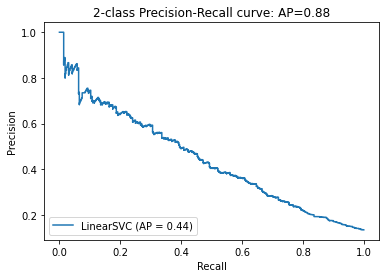

In [98]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prec_svc))